## **Task 1: Most accuate and most fair models**

The following is a study of hyperparameter tuning in the context of supervised machine learning to find the most optimal parameters that balances accuracy and fairness metrics to make the machine learning models more human oriented. The task is to classify two groups of people. The study is performed on two datasets from the aif360[LFR] library, namely **Adult Income** and **German**. The classification is done based on the feature "sex" and the model used is **Support Vector Machine (SVM)**. 

The first task is to install the aif360[LFR] library, navigate to the correct directory and import the dataset

In [ ]:
!pip install 'aif360[LFR]'

### Adult dataset

In [ ]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

In [ ]:
pip install fairlearn

In [ ]:
pip install scikit-lego

In [6]:
# import all necessary libraries

import numpy as np
import pandas as pd
from aif360.datasets import AdultDataset, GermanDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_german
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
import pdb
import random
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import *
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklego.metrics import equal_opportunity_score

np.random.seed(0)

The following function takes in the name of the dataset and configures privileged and unprivileged classes with a value of 1 and 0 respectively for training and splits the dataset into training and test sets by a 7:3 ratio. We first perform all operations on the adult dataset to find out the hyperparameter values for the most accurate model (model that gives highest accuracy on train set) and for the most fair model that will have displayed equal opportunity for both classes (although accuracy might be lower) and serves as a more generalized model. The purpose of maintaining a balance between accuracy and fairness helps machine learning models to not become overfitted so that they can be applied to multiple datasets to a certain accuracy and also to make machine learning decisions more human oriented.

In [7]:
def import_dataset(dataset):
  privileged = [{'sex': 1}]
  unprivileged = [{'sex': 0}]
  dataset_original = dataset(['sex'])


  train, test = dataset_original.split([0.7], shuffle=True)
  print("training data size", train.features.shape)
  print("dataset feature names", train.feature_names)

  scale_orig = StandardScaler()
  X_train = scale_orig.fit_transform(train.features)
  y_train = train.labels.ravel()

  X_test = scale_orig.transform(test.features) 
  y_test = test.labels.ravel()

  return privileged, unprivileged, train, test, X_train, y_train, X_test, y_test

The following function takes the range of hyperparameters we are testing along with all training and test sets. For our SVM model, we will be varying the regularization term C and the gamma value to find the combination of the two that give the most accurate model and the most fair model. Another similar function has been defined below for hyperparameter tuning using sample weights.

In [8]:
def hyperparameter_tuning(c_val, gamma_val, X_train, y_train):
  
  folds = StratifiedKFold(n_splits=5)
  accuracy_score = {}
  equality_error = {}
  i_val = []
  j_val = []

  for i in c_val:
    for j in gamma_val:
      score = []
      eod = []
      for train_index, test_index in folds.split(X_train, y_train):
        X_trn, X_tst, y_trn, y_tst = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
        mod = SVC(C=i, gamma=j, kernel='rbf')
        mod.fit(X_trn, y_trn)
        score.append(mod.score(X_tst, y_tst))
        predictions = mod.predict(X_tst)
       
        tot_pos = 0
        tot_neg = 0

        for val in range(len(predictions)):
          if y_tst[val]==1:
            tot_pos+=1
          if y_tst[val]==0:
            tot_neg+=1
          else:
            continue

        p = 0
        n = 0
        for val in range(len(predictions)):
          if y_tst[val]==1 and y_tst[val]==predictions[val]:
            p+=1
          if y_tst[val]==0 and y_tst[val]==predictions[val]:
            n+=1
          else:
            continue

        if tot_pos==0:
          equal_opportunity_diff = 0
        elif tot_neg==0:
          equal_opportunity_diff = 0
        else:
          equal_opportunity_diff = abs((p/tot_pos)-(n/tot_neg))
        
        eod.append(equal_opportunity_diff)

      i_val.append(i)
      j_val.append(j)
      accuracy_score["C="+str(i)+"_gamma="+str(j)] = np.average(score)
      
      equality_error["C="+str(i)+"_gamma="+str(j)] = np.average(eod)


  print("Maximum accuracy value on training set: ", round((max(accuracy_score.values())*100),2), "%")
  #print("Hyperparameter values to achieve maximum accuracy: ", list(accuracy_score.keys())[list(accuracy_score.values()).index(max(accuracy_score.values()))])
  print("Hyperparameter values to achieve maximum accuracy: ", [k for k,v in accuracy_score.items() if v == max(accuracy_score.values())])  
  print("Minimum error value: ", round(min(equality_error.values(), key=abs),4))
  print("Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes): ", [k for k,v in equality_error.items() if v == min(equality_error.values(), key=abs)])

  return i_val, j_val, accuracy_score, equality_error


In [9]:
def weighted_hyperparameter_tuning(c_val, gamma_val, X_train, y_train, weights):
  
  folds = StratifiedKFold(n_splits=5)
  accuracy_score = {}
  equality_error = {}
  i_val = []
  j_val = []

  for i in c_val:
    for j in gamma_val:
      score = []
      eod = []
      for train_index, test_index in folds.split(X_train, y_train):
        X_trn, X_tst, y_trn, y_tst = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
        mod = SVC(C=i, gamma=j, kernel='rbf')
        mod.fit(X_trn, y_trn, sample_weight=weights[train_index])     #sample weights
        score.append(mod.score(X_tst, y_tst))
        predictions = mod.predict(X_tst)

        tot_pos = 0
        tot_neg = 0

        for val in range(len(predictions)):
          if y_tst[val]==1:
            tot_pos+=1
          if y_tst[val]==0:
            tot_neg+=1
          else:
            continue

        p = 0
        n = 0
        for val in range(len(predictions)):
          if y_tst[val]==1 and y_tst[val]==predictions[val]:
            p+=1
          if y_tst[val]==0 and y_tst[val]==predictions[val]:
            n+=1
          else:
            continue

        if tot_pos==0:
          equal_opportunity_diff = 0
        elif tot_neg==0:
          equal_opportunity_diff = 0
        else:
          equal_opportunity_diff = abs((p/tot_pos)-(n/tot_neg))
        
        eod.append(equal_opportunity_diff)
      
      i_val.append(i)
      j_val.append(j)

      accuracy_score["C="+str(i)+"_gamma="+str(j)] = np.average(score)
      
      equality_error["C="+str(i)+"_gamma="+str(j)] = np.average(eod)


  print("Maximum accuracy value on training set: ", round((max(accuracy_score.values())*100),2), "%")
  #print("Hyperparameter values to achieve maximum accuracy: ", list(accuracy_score.keys())[list(accuracy_score.values()).index(max(accuracy_score.values()))])
  print("Hyperparameter values to achieve maximum accuracy: ", [k for k,v in accuracy_score.items() if v == max(accuracy_score.values())])
  print("Minimum error value: ", round(min(equality_error.values(), key=abs),4))
  print("Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes): ", [k for k,v in equality_error.items() if v == min(equality_error.values(), key=abs)])

  return i_val, j_val, accuracy_score, equality_error

The following two blocks of codes are functions to run specific combinations of C and gamma as input by user to print the accuracy and fairness metrics of an SVM model. Similar to before, there are two functions for the same, one considers sample weights and the other does not.

In [10]:
def model_run(svm, X_train, X_test, y_train, y_test, test, unprivileged, privileged):

  folds = StratifiedKFold(n_splits=5)
  for train_ind, test_ind in folds.split(X_train, y_train):
    X_trn, X_tst, y_trn, y_tst = X_train[train_ind], X_train[test_ind], y_train[train_ind], y_train[test_ind]
    mod_try = svm
    mod_try.fit(X_trn, y_trn)

  predict_test = mod_try.predict(X_test)
  test_pred_try = test.copy()
  test_pred_try.labels = predict_test
  print("Accuracy on test: ", round((mod_try.score(X_test, y_test)*100),2), "%")

  f_metric = ClassificationMetric(test, test_pred_try, unprivileged_groups=unprivileged, privileged_groups=privileged)

  print("Equal opportunity difference: ", round(f_metric.equal_opportunity_difference(),3))
  print("Disparate Impact: ", round(f_metric.disparate_impact(),3))

  print(confusion_matrix(test.labels, test_pred_try.labels))



In [11]:
def weighted_model_run(svm, X_train, X_test, y_train, y_test, test, unprivileged, privileged, weights):

  folds = StratifiedKFold(n_splits=5)
  for train_ind, test_ind in folds.split(X_train, y_train):
    X_trn, X_tst, y_trn, y_tst = X_train[train_ind], X_train[test_ind], y_train[train_ind], y_train[test_ind]
    mod_try = svm
    mod_try.fit(X_trn, y_trn, sample_weight=weights[train_ind])     #sample weights

  predict_test = mod_try.predict(X_test)
  test_pred_try = test.copy()
  test_pred_try.labels = predict_test
  print("Accuracy on test: ", round((mod_try.score(X_test, y_test)*100),2), "%")

  f_metric = ClassificationMetric(test, test_pred_try, unprivileged_groups=unprivileged, privileged_groups=privileged)
  print("Equal opportunity difference: ", round(f_metric.equal_opportunity_difference(),3))
  print("Disparate Impact: ", round(f_metric.disparate_impact(),3))

  print(confusion_matrix(test.labels, test_pred_try.labels))



Our analysis begins below. First we import the Adult Income dataset by utilizing the function *import_dataset* and assigning the values returned for the next steps (i.e., train and test sets). We get to see a bit about the data and the number and types of features in the dataset. To see the effect of changing the parameter values, we will first vary only reglarization term C keeping gamma constant and then plot the respective accuracy and fairness quotients against the C values. 

In [12]:
privileged_adult, unprivileged_adult, train_ad, test_ad, X_train_ad, y_train_ad, X_test_ad, y_test_ad = import_dataset(load_preproc_data_adult)

training data size (34189, 18)
dataset feature names ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


Maximum accuracy value on training set:  80.39 %
Hyperparameter values to achieve maximum accuracy:  ['C=1.142105263157895_gamma=0.1']
Minimum error value:  0.5392
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=2.7052631578947373_gamma=0.1', 'C=3.2263157894736847_gamma=0.1', 'C=3.747368421052632_gamma=0.1', 'C=4.268421052631579_gamma=0.1', 'C=4.7894736842105265_gamma=0.1', 'C=5.310526315789474_gamma=0.1', 'C=5.831578947368421_gamma=0.1', 'C=6.352631578947369_gamma=0.1', 'C=6.873684210526316_gamma=0.1', 'C=7.394736842105264_gamma=0.1', 'C=7.915789473684211_gamma=0.1', 'C=8.436842105263159_gamma=0.1', 'C=8.957894736842105_gamma=0.1', 'C=9.478947368421053_gamma=0.1', 'C=10.0_gamma=0.1']


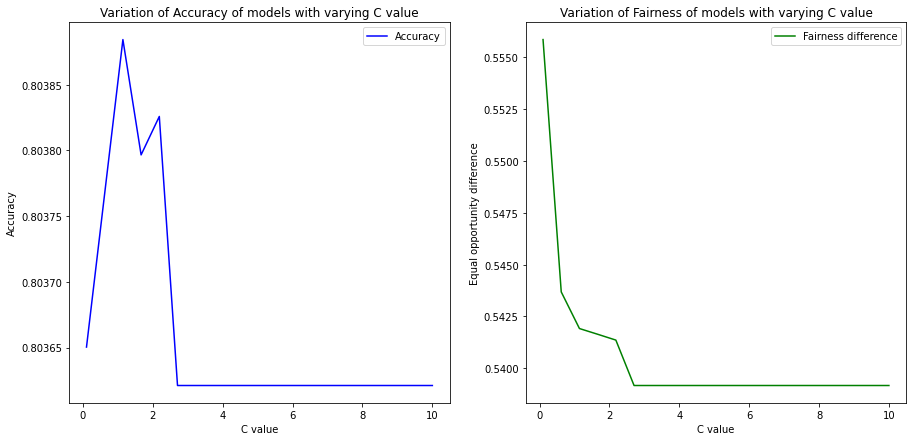

In [13]:
c_variable = list(np.linspace(0.1, 10, 20))
gamma_const = [0.1]

x_for_c, ignore1, y_accuracy_varc, y_error_varc = hyperparameter_tuning(c_variable, gamma_const, X_train_ad, y_train_ad)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(x_for_c, list(y_accuracy_varc.values()), color='blue', label="Accuracy")
plt.title("Variation of Accuracy of models with varying C value")
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_for_c, list(y_error_varc.values()), color='green', label="Fairness difference")
plt.title("Variation of Fairness of models with varying C value")
plt.xlabel('C value')
plt.ylabel('Equal opportunity difference')

plt.legend()
plt.show()

We will again plot accuracy and fairness metrics but this time, against a varying gamma value while keeping C constant.

Maximum accuracy value on training set:  80.39 %
Hyperparameter values to achieve maximum accuracy:  ['C=1_gamma=0.1061578947368421', 'C=1_gamma=0.15873684210526315', 'C=1_gamma=0.2113157894736842', 'C=1_gamma=0.26389473684210524']
Minimum error value:  0.4132
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=1_gamma=0.001']


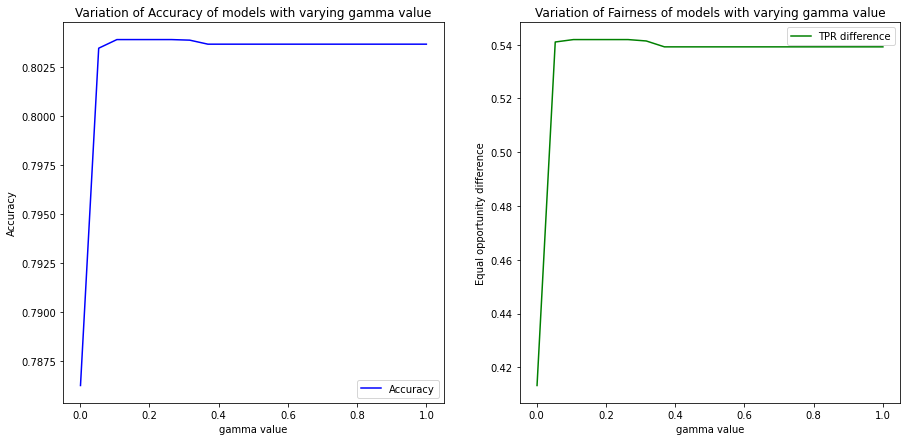

In [14]:
c_const = [1]
gamma_variable = list(np.linspace(0.001, 1, 20))

ignore2, x_for_g, y_accuracy_varg, y_error_varg = hyperparameter_tuning(c_const, gamma_variable, X_train_ad, y_train_ad)


plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(x_for_g, list(y_accuracy_varg.values()), color='blue', label="Accuracy")
plt.title("Variation of Accuracy of models with varying gamma value")
plt.xlabel('gamma value')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_for_g, list(y_error_varg.values()), color='green', label="TPR difference")
plt.title("Variation of Fairness of models with varying gamma value")
plt.xlabel('gamma value')
plt.ylabel('Equal opportunity difference')

plt.legend()
plt.show()

Now that we have got a rough idea about how changing the parameters affects our results, we tune both C value and gamma to find the reqired combinations as outlined earlier. A few selected values of C and gamma have been provided that will be checked. A more thorough check would be to provide range of values but it was found to increase computation time by a lot with no real improvement in results. Using Randomized search CV does cut down on the computation time but we have not used it because when the C values and gamma generated by np.linspace, Randomized search CV was sometimes found to not select the better combination when tuned randomly (compared to previous trials). It will of course be better if more random combinations are tested but it again increases computation time.

In [15]:
c_variable = [0.1, 1, 10]
gamma_variable = [0.001, 0.01, 0.1, 1]

a, b, c, d = hyperparameter_tuning(c_variable, gamma_variable, X_train_ad, y_train_ad)


Maximum accuracy value on training set:  80.38 %
Hyperparameter values to achieve maximum accuracy:  ['C=1_gamma=0.1']
Minimum error value:  0.4132
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=1_gamma=0.001']


Below is a 3D representation of the resulting values. It is a bit difficult to visualize the results hence a dataframe is also generated for tabular representation.

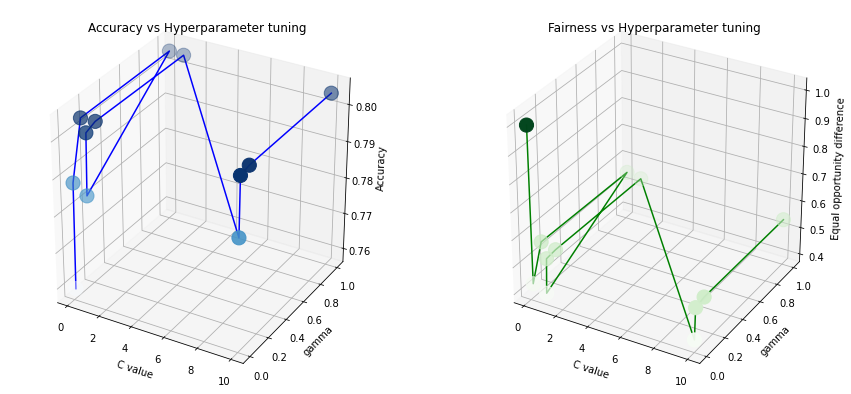

In [16]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(121, projection='3d')
ax.plot3D(a, b, list(c.values()), color='b')
ax.scatter3D(a, b, list(c.values()), c=list(c.values()), cmap='Blues', s=200)
ax.set_title("Accuracy vs Hyperparameter tuning")
ax.set_xlabel("C value")
ax.set_ylabel("gamma")
ax.set_zlabel("Accuracy")

ax = fig.add_subplot(122, projection='3d')
ax.plot3D(a, b, list(d.values()), color='g')
ax.scatter3D(a, b, list(d.values()), c=list(d.values()), cmap='Greens', s=200)
ax.set_title("Fairness vs Hyperparameter tuning")
ax.set_xlabel("C value")
ax.set_ylabel("gamma")
ax.set_zlabel("Equal opportunity difference")

plt.show()

The fairness metric that we have considered is **Equal opportunity difference**. It is the difference between the true positive rates for both the classes. i.e. whether the number of positive or negative predictions (both true and false) are similar for both classes and treats them evenly. A value close to zero will display that, whereas a high difference value will demostrate uneven representation and bias.



For better visualization, we convert the dictionaries of accuracy and Equal opportunity difference to a pandas dataframe. We sort it first by descending order of accuracy and next by ascending order of Equal opportunity difference and verify that the hyperparameter values are in fact as displayed in the output. Which they are.

In [17]:
df_adult = pd.DataFrame(c.items(), columns=['Hyperparameters', 'Accuracy'])

df_adult["Equality difference"] = df_adult["Hyperparameters"].map(d)
df_adult.sort_values(by=["Accuracy"], ascending=False)

,Hyperparameters,Accuracy,Equality difference
6,C=1_gamma=0.1,0.803826,0.543279
3,C=0.1_gamma=1,0.803797,0.548683
7,C=1_gamma=1,0.803650,0.539205
11,C=10_gamma=1,0.803650,0.539205
2,C=0.1_gamma=0.1,0.803650,0.555855
10,C=10_gamma=0.1,0.803621,0.539167
9,C=10_gamma=0.01,0.802978,0.530635
5,C=1_gamma=0.01,0.802714,0.538453
1,C=0.1_gamma=0.01,0.788382,0.428807
8,C=10_gamma=0.001,0.787154,0.416623


In [18]:
df_adult["Absolute difference"]=abs(df_adult["Equality difference"])
df_adult.sort_values(by=["Absolute difference"])

,Hyperparameters,Accuracy,Equality difference,Absolute difference
4,C=1_gamma=0.001,0.786276,0.413226,0.413226
8,C=10_gamma=0.001,0.787154,0.416623,0.416623
1,C=0.1_gamma=0.01,0.788382,0.428807,0.428807
9,C=10_gamma=0.01,0.802978,0.530635,0.530635
5,C=1_gamma=0.01,0.802714,0.538453,0.538453
10,C=10_gamma=0.1,0.803621,0.539167,0.539167
7,C=1_gamma=1,0.803650,0.539205,0.539205
11,C=10_gamma=1,0.803650,0.539205,0.539205
6,C=1_gamma=0.1,0.803826,0.543279,0.543279
3,C=0.1_gamma=1,0.803797,0.548683,0.548683


We create a new column in the dataframe called **Absolute difference** which is the absoluted value of EOD. It helps to understand how far exactly a point is from the 0 mark. From our output we can see that the SVC(C=1, gamma=0.1) model has the highest accuracy on the training set, 80.38% but also has a high EOD (-0.437037). It might be the most accurate but not the most fair. Far fairness, we take a look at the next table which shows that SVC(C=0.1, gamma=0.001) has 0.0 EOD and thereby the most fair but the accuracy drops down to almost 76%. Proper considerations need to be made to seelct the most optimum parameters.






Our next job is to apply the respective models with parameters obtained above on the test sets to see how they fare.

In [19]:
model_run(SVC(C=1, gamma=0.1, kernel='rbf'), X_train_ad, X_test_ad, y_train_ad, y_test_ad, test_ad, unprivileged_adult, privileged_adult)

Accuracy on test:  80.37 %
Equal opportunity difference:  -0.437
Disparate Impact:  0.0
[[10479   712]
 [ 2164  1298]]


In [20]:
model_run(SVC(C=1, gamma=0.001, kernel='rbf'), X_train_ad, X_test_ad, y_train_ad, y_test_ad, test_ad, unprivileged_adult, privileged_adult)

Accuracy on test:  78.74 %
Equal opportunity difference:  0.033
Disparate Impact:  0.712
[[9941 1250]
 [1865 1597]]


As expected, higher values of C and gamma contributed towards the most accuracy. It would make sense because a high value of C implies higher penalties on points classified incorrectly so the model tries to minimize misclassifications thereby increasing accuracy. Whereas a higher value of gamma implies class similarity within a smaller space. If gamma is low, as in the fair model, it considers similarities in the samples across larger distances and may therefore classify incorrectly (with low penalties as well if C is low as in fair model). This shows that a fairer model is more generalizable but lower on accuracy.




We perform all the above task again on a new dataset called **German** where again, classification is based on a protected feature **"sex"** and the model is still SVM.

In [ ]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/german

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc

In [23]:
privileged_german, unprivileged_german, train_ge, test_ge, X_train_ge, y_train_ge, X_test_ge, y_test_ge = import_dataset(load_preproc_data_german)

training data size (700, 11)
dataset feature names ['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


In [24]:
c_variable_g = list(np.linspace(0.1, 1, 10))
gamma_variable_g = list(np.linspace(0.001, 1, 10))

e, f, g, h = hyperparameter_tuning(c_variable_g, gamma_variable_g, X_train_ge, y_train_ge)


Maximum accuracy value on training set:  71.86 %
Hyperparameter values to achieve maximum accuracy:  ['C=0.5_gamma=0.445', 'C=0.5_gamma=0.556', 'C=0.5_gamma=0.667', 'C=0.5_gamma=0.778', 'C=0.5_gamma=0.889', 'C=0.5_gamma=1.0', 'C=0.6_gamma=0.334', 'C=0.6_gamma=0.445', 'C=0.6_gamma=0.556', 'C=0.6_gamma=0.667', 'C=0.6_gamma=0.778', 'C=0.6_gamma=0.889', 'C=0.6_gamma=1.0', 'C=0.7000000000000001_gamma=0.334', 'C=0.7000000000000001_gamma=0.445', 'C=0.7000000000000001_gamma=0.556', 'C=0.7000000000000001_gamma=0.667', 'C=0.7000000000000001_gamma=0.778', 'C=0.7000000000000001_gamma=0.889', 'C=0.7000000000000001_gamma=1.0']
Minimum error value:  0.0
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=0.1_gamma=0.001', 'C=0.1_gamma=0.112', 'C=0.1_gamma=0.223', 'C=0.1_gamma=0.334', 'C=0.1_gamma=0.445', 'C=0.1_gamma=0.556', 'C=0.1_gamma=0.667', 'C=0.1_gamma=0.778', 'C=0.1_gamma=0.889', 'C=0.1_gamma=1.0', 'C=0.2_gamma=0.001', 'C=0.2_gamma=0.112', 'C=0.2_g

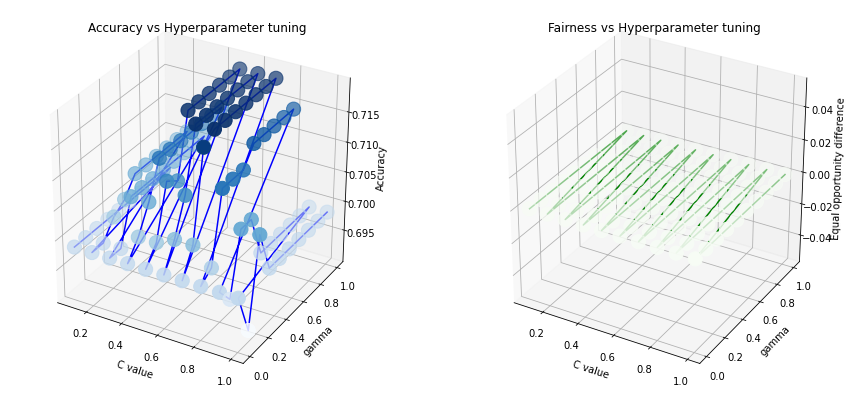

In [25]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(121, projection='3d')
ax.plot3D(e, f, list(g.values()), color='b')
ax.scatter3D(e, f, list(g.values()), c=list(g.values()), cmap='Blues', s=200)
ax.set_title("Accuracy vs Hyperparameter tuning")
ax.set_xlabel("C value")
ax.set_ylabel("gamma")
ax.set_zlabel("Accuracy")

ax = fig.add_subplot(122, projection='3d')
ax.plot3D(e, f, list(h.values()), color='g')
ax.scatter3D(e, f, list(h.values()), c=list(h.values()), cmap='Greens', s=200)
ax.set_title("Fairness vs Hyperparameter tuning")
ax.set_xlabel("C value")
ax.set_ylabel("gamma")
ax.set_zlabel("Equal opportunity difference")

plt.show()

In [66]:
df_german = pd.DataFrame(g.items(), columns=['Hyperparameters', 'Accuracy'])

df_german["Equality difference"] = df_german["Hyperparameters"].map(h)
df_german["Absolute difference"]=abs(df_german["Equality difference"])

df_german.sort_values(by=["Accuracy"], ascending=False)

,Hyperparameters,Accuracy,Equality difference,Absolute difference
56,C=0.6_gamma=0.667,0.718571,0.0,0.0
47,C=0.5_gamma=0.778,0.718571,0.0,0.0
49,C=0.5_gamma=1.0,0.718571,0.0,0.0
53,C=0.6_gamma=0.334,0.718571,0.0,0.0
54,C=0.6_gamma=0.445,0.718571,0.0,0.0
...,...,...,...,...
1,C=0.1_gamma=0.112,0.698571,0.0,0.0
60,C=0.7000000000000001_gamma=0.001,0.698571,0.0,0.0
99,C=1.0_gamma=1.0,0.698571,0.0,0.0
81,C=0.9_gamma=0.112,0.695714,0.0,0.0


In [26]:
model_run(SVC(C=0.5, gamma=0.445, kernel='rbf'), X_train_ge, X_test_ge, y_train_ge, y_test_ge, test_ge, unprivileged_german, privileged_german)

Accuracy on test:  71.67 %
Equal opportunity difference:  -0.067
Disparate Impact:  0.838
[[203   8]
 [ 77  12]]


In [27]:
model_run(SVC(C=0.1, gamma=0.001, kernel='rbf'), X_train_ge, X_test_ge, y_train_ge, y_test_ge, test_ge, unprivileged_german, privileged_german)

Accuracy on test:  70.33 %
Equal opportunity difference:  0.0
Disparate Impact:  1.0
[[211   0]
 [ 89   0]]


.

.

.

.

## **Task 2: Reweighing**

In the next part, we use a method called reweighing to reduce the sample variance and improve the model performance. In this method, there is a set of weights applied to each input feature in the training phase, depending upon its contribution to the final result. This method helps improve the fairness metrics of the model. Folllowing the training, we receive new parameter combinations (C and gamma) for most accurate and most fair SVM models respectively on the Adult dataset..

In [28]:
RW_adult = Reweighing(unprivileged_groups=unprivileged_adult, privileged_groups=privileged_adult)
RW_german = Reweighing(unprivileged_groups=unprivileged_german, privileged_groups=privileged_german)

train_ad = RW_adult.fit_transform(train_ad)
train_ge = RW_german.fit_transform(train_ge)

In [29]:
c_variable = [0.1, 1, 10]
gamma_var = [0.001, 0.01, 0.1, 1]

rwa, rwb, rwc, rwd = weighted_hyperparameter_tuning(c_variable, gamma_var, X_train_ad, y_train_ad, train_ad.instance_weights)

Maximum accuracy value on training set:  78.99 %
Hyperparameter values to achieve maximum accuracy:  ['C=10_gamma=0.01']
Minimum error value:  0.4132
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=1_gamma=0.001', 'C=10_gamma=0.001']


In [30]:
df_adult_rw = pd.DataFrame(rwc.items(), columns=['Hyperparameters', 'Accuracy'])

df_adult_rw["Equality difference"] = df_adult_rw["Hyperparameters"].map(rwd)
df_adult_rw["Absolute difference"]=abs(df_adult_rw["Equality difference"])
df_adult_rw.sort_values(by=["Absolute difference"])


,Hyperparameters,Accuracy,Equality difference,Absolute difference
4,C=1_gamma=0.001,0.786276,0.413226,0.413226
8,C=10_gamma=0.001,0.786276,0.413226,0.413226
1,C=0.1_gamma=0.01,0.787359,0.423937,0.423937
5,C=1_gamma=0.01,0.787446,0.424052,0.424052
9,C=10_gamma=0.01,0.789903,0.449381,0.449381
2,C=0.1_gamma=0.1,0.788938,0.482530,0.482530
11,C=10_gamma=1,0.785604,0.495911,0.495911
10,C=10_gamma=0.1,0.785838,0.497019,0.497019
6,C=1_gamma=0.1,0.786306,0.499717,0.499717
7,C=1_gamma=1,0.786335,0.499915,0.499915


In [31]:
weighted_model_run(SVC(C=10, gamma=0.01, kernel='rbf'), X_train_ad, X_test_ad, y_train_ad, y_test_ad, test_ad, unprivileged_adult, privileged_adult, train_ad.instance_weights)

Accuracy on test:  79.04 %
Equal opportunity difference:  0.034
Disparate Impact:  0.704
[[10079  1112]
 [ 1959  1503]]


In [32]:
weighted_model_run(SVC(C=1, gamma=0.001, kernel='rbf'), X_train_ad, X_test_ad, y_train_ad, y_test_ad, test_ad, unprivileged_adult, privileged_adult, train_ad.instance_weights)

Accuracy on test:  78.74 %
Equal opportunity difference:  0.033
Disparate Impact:  0.712
[[9941 1250]
 [1865 1597]]


So we can see that the equal opportunity difference did decrease for the most accurate model and overall as well. Weighing the samples during training did decrease the variance. The accuracy value went down a bit but is comparable to before.

## Now on German dataset

In [33]:
c_variable = list(np.linspace(0.1, 1, 20))
gamma_value = list(np.linspace(0.001, 1, 20))

rwe, rwf, rwg, rwh = weighted_hyperparameter_tuning(c_variable, gamma_value, X_train_ge, y_train_ge, train_ge.instance_weights)


Maximum accuracy value on training set:  71.14 %
Hyperparameter values to achieve maximum accuracy:  ['C=0.2894736842105263_gamma=0.5267894736842105', 'C=0.2894736842105263_gamma=0.5793684210526315', 'C=0.2894736842105263_gamma=0.6319473684210526', 'C=0.2894736842105263_gamma=0.6845263157894736', 'C=0.2894736842105263_gamma=0.7371052631578947', 'C=0.2894736842105263_gamma=0.7896842105263158', 'C=0.2894736842105263_gamma=0.8422631578947368', 'C=0.2894736842105263_gamma=0.8948421052631579', 'C=0.2894736842105263_gamma=0.9474210526315789', 'C=0.2894736842105263_gamma=1.0', 'C=0.33684210526315794_gamma=0.3164736842105263']
Minimum error value:  0.0
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=0.1_gamma=0.001', 'C=0.1_gamma=0.05357894736842105', 'C=0.1_gamma=0.1061578947368421', 'C=0.1_gamma=0.15873684210526315', 'C=0.1_gamma=0.2113157894736842', 'C=0.1_gamma=0.26389473684210524', 'C=0.1_gamma=0.3164736842105263', 'C=0.1_gamma=0.369052631

In [34]:
df_german_rw = pd.DataFrame(rwg.items(), columns=['Hyperparameters', 'Accuracy'])

df_german_rw["Equality difference"] = df_german_rw["Hyperparameters"].map(rwh)
df_german_rw.sort_values(by=["Accuracy"], ascending=False)

,Hyperparameters,Accuracy,Equality difference
91,C=0.2894736842105263_gamma=0.5793684210526315,0.711429,0.0
92,C=0.2894736842105263_gamma=0.6319473684210526,0.711429,0.0
93,C=0.2894736842105263_gamma=0.6845263157894736,0.711429,0.0
94,C=0.2894736842105263_gamma=0.7371052631578947,0.711429,0.0
95,C=0.2894736842105263_gamma=0.7896842105263158,0.711429,0.0
...,...,...,...
82,C=0.2894736842105263_gamma=0.1061578947368421,0.698571,0.0
81,C=0.2894736842105263_gamma=0.05357894736842105,0.698571,0.0
80,C=0.2894736842105263_gamma=0.001,0.698571,0.0
63,C=0.24210526315789474_gamma=0.15873684210526315,0.698571,0.0


In [35]:
df_german_rw["Absolute difference"]=abs(df_german_rw["Equality difference"])
df_german_rw.sort_values(by=["Absolute difference"])

,Hyperparameters,Accuracy,Equality difference,Absolute difference
0,C=0.1_gamma=0.001,0.698571,0.0,0.0
272,C=0.7157894736842105_gamma=0.6319473684210526,0.705714,0.0,0.0
271,C=0.7157894736842105_gamma=0.5793684210526315,0.705714,0.0,0.0
270,C=0.7157894736842105_gamma=0.5267894736842105,0.705714,0.0,0.0
269,C=0.7157894736842105_gamma=0.47421052631578947,0.705714,0.0,0.0
...,...,...,...,...
128,C=0.38421052631578945_gamma=0.4216315789473684,0.710000,0.0,0.0
127,C=0.38421052631578945_gamma=0.36905263157894735,0.710000,0.0,0.0
126,C=0.38421052631578945_gamma=0.3164736842105263,0.710000,0.0,0.0
136,C=0.38421052631578945_gamma=0.8422631578947368,0.710000,0.0,0.0


Similar results of fairness improvement found on the German dataset as well. This implies that the true positive rate for both the classes is similar which means our model is not biased.

In [36]:
weighted_model_run(SVC(C=0.2894736842105263, gamma=0.5267894736842105, kernel='rbf'), X_train_ge, X_test_ge, y_train_ge, y_test_ge, test_ge, unprivileged_german, privileged_german, train_ge.instance_weights)

Accuracy on test:  69.67 %
Equal opportunity difference:  0.02
Disparate Impact:  1.019
[[208   3]
 [ 88   1]]


In [37]:
weighted_model_run(SVC(C=0.1, gamma=0.001, kernel='rbf'), X_train_ge, X_test_ge, y_train_ge, y_test_ge, test_ge, unprivileged_german, privileged_german, train_ge.instance_weights)

Accuracy on test:  70.33 %
Equal opportunity difference:  0.0
Disparate Impact:  1.0
[[211   0]
 [ 89   0]]


.

.

.

.

.

.

# **Task 3: Most optimal parameters**

Here we have a basic scoring sytem for the models derived above. To come up with the most optimal parameters for a model we have to understand its requirements. If it is skewed more towards accuracy or fairness. 

From the tables generated after hyperparameter tuning and training the models, of all the combinations, the one with the lowest accuracy is given a score of 1 and the one with the highest, a score of 10. The range within the highest and lowest accuracy is split into 10 equal parts and the remaining models get a score between 1 and 10 depending upon the accuracy. The same idea is used for the fairness metric but where the minimum TPR difference is given the highest score. At the end we just add the accuracy and fairness scores to have a rough idea about where each model stands.

In [61]:
def scoring_models(testdf):

  testdf["Accuracy"] = round(testdf["Accuracy"]*100, 2)
  testdf["Equality difference"] = round(testdf["Equality difference"], 3)
  testdf["Absolute difference"] = round(testdf["Absolute difference"], 3)

  testdf["Accuracy score"] = testdf["Accuracy"]*0
  testdf["Fairness score"] = testdf["Accuracy"]*0
  testdf


  min = testdf["Accuracy"].min()
  max = testdf["Accuracy"].max()
  step = (max-min)/10

  for av in range(len(testdf["Accuracy"])):
    
    if testdf["Accuracy"][av]>=min and testdf["Accuracy"][av]<min+step:
      testdf["Accuracy score"][av]=1
    elif testdf["Accuracy"][av]>=min+step and testdf["Accuracy"][av]<min+(step*2):
      testdf["Accuracy score"][av]=2
    elif testdf["Accuracy"][av]>=min+(step*2) and testdf["Accuracy"][av]<min+(step*3):
      testdf["Accuracy score"][av]=3
    elif testdf["Accuracy"][av]>=min+(step*3) and testdf["Accuracy"][av]<min+(step*4):
      testdf["Accuracy score"][av]=4
    elif testdf["Accuracy"][av]>=min+(step*4) and testdf["Accuracy"][av]<min+(step*5):
      testdf["Accuracy score"][av]=5
    elif testdf["Accuracy"][av]>=min+(step*5) and testdf["Accuracy"][av]<min+(step*6):
      testdf["Accuracy score"][av]=6
    elif testdf["Accuracy"][av]>=min+(step*6) and testdf["Accuracy"][av]<min+(step*7):
      testdf["Accuracy score"][av]=7
    elif testdf["Accuracy"][av]>=min+(step*7) and testdf["Accuracy"][av]<min+(step*8):
      testdf["Accuracy score"][av]=8
    elif testdf["Accuracy"][av]>=min+(step*8) and testdf["Accuracy"][av]<min+(step*9):
      testdf["Accuracy score"][av]=9
    elif testdf["Accuracy"][av]>=min+(step*9):
      testdf["Accuracy score"][av]=10



  low = testdf["Absolute difference"].min()
  high = testdf["Absolute difference"].max()
  gap = (high-low)/10


  for fv in range(len(testdf["Absolute difference"])):
  
    if testdf["Absolute difference"][fv]>=low and testdf["Absolute difference"][fv]<low+gap:
      testdf["Fairness score"][fv]=10
    elif testdf["Absolute difference"][fv]>=low+gap and testdf["Absolute difference"][fv]<low+(gap*2):
      testdf["Fairness score"][fv]=9
    elif testdf["Absolute difference"][fv]>=low+(gap*2) and testdf["Absolute difference"][fv]<low+(gap*3):
      testdf["Fairness score"][fv]=8
    elif testdf["Absolute difference"][fv]>=low+(gap*3) and testdf["Absolute difference"][fv]<low+(gap*4):
      testdf["Fairness score"][fv]=7
    elif testdf["Absolute difference"][fv]>=low+(gap*4) and testdf["Absolute difference"][fv]<low+(gap*5):
      testdf["Fairness score"][fv]=6
    elif testdf["Absolute difference"][fv]>=low+(gap*5) and testdf["Absolute difference"][fv]<low+(gap*6):
      testdf["Fairness score"][fv]=5
    elif testdf["Absolute difference"][fv]>=low+(gap*6) and testdf["Absolute difference"][fv]<low+(gap*7):
      testdf["Fairness score"][fv]=4
    elif testdf["Absolute difference"][fv]>=low+(gap*7) and testdf["Absolute difference"][fv]<low+(gap*8):
      testdf["Fairness score"][fv]=3
    elif testdf["Absolute difference"][fv]>=low+(gap*8) and testdf["Absolute difference"][fv]<low+(gap*9):
      testdf["Fairness score"][fv]=2
    elif testdf["Absolute difference"][fv]>=low+(gap*9):
      testdf["Fairness score"][fv]=1


  testdf["Total_score"] = testdf["Accuracy score"]+testdf["Fairness score"]
  testdf = testdf.sort_values(by=["Total_score"], ascending=False)
    
    
  return testdf

In [ ]:
nw_adult = scoring_models(df_adult)
rewt_adult = scoring_models(df_adult_rw)

In [63]:
nw_adult

,Hyperparameters,Accuracy,Equality difference,Absolute difference,Accuracy score,Fairness score,Total_score
2,C=0.1_gamma=0.1,8.037000e+11,0.556,0.556,10.0,8.0,18.0
3,C=0.1_gamma=1,8.038000e+11,0.549,0.549,10.0,8.0,18.0
5,C=1_gamma=0.01,8.027000e+11,0.538,0.538,10.0,8.0,18.0
6,C=1_gamma=0.1,8.038000e+11,0.543,0.543,10.0,8.0,18.0
7,C=1_gamma=1,8.037000e+11,0.539,0.539,10.0,8.0,18.0
9,C=10_gamma=0.01,8.030000e+11,0.531,0.531,10.0,8.0,18.0
10,C=10_gamma=0.1,8.036000e+11,0.539,0.539,10.0,8.0,18.0
11,C=10_gamma=1,8.037000e+11,0.539,0.539,10.0,8.0,18.0
1,C=0.1_gamma=0.01,7.884000e+11,0.429,0.429,7.0,10.0,17.0
4,C=1_gamma=0.001,7.863000e+11,0.413,0.413,7.0,10.0,17.0


In [64]:
rewt_adult

,Hyperparameters,Accuracy,Equality difference,Absolute difference,Accuracy score,Fairness score,Total_score
1,C=0.1_gamma=0.01,78740000.0,0.424,0.424,10.0,10.0,20.0
5,C=1_gamma=0.01,78740000.0,0.424,0.424,10.0,10.0,20.0
9,C=10_gamma=0.01,78990000.0,0.449,0.449,10.0,10.0,20.0
2,C=0.1_gamma=0.1,78890000.0,0.483,0.483,10.0,9.0,19.0
3,C=0.1_gamma=1,78750000.0,0.523,0.523,10.0,9.0,19.0
4,C=1_gamma=0.001,78630000.0,0.413,0.413,9.0,10.0,19.0
8,C=10_gamma=0.001,78630000.0,0.413,0.413,9.0,10.0,19.0
6,C=1_gamma=0.1,78630000.0,0.500,0.500,9.0,9.0,18.0
7,C=1_gamma=1,78630000.0,0.500,0.500,9.0,9.0,18.0
10,C=10_gamma=0.1,78580000.0,0.497,0.497,9.0,9.0,18.0


In [48]:
model_run(SVC(C=0.1, gamma=0.1, kernel='rbf'), X_train_ad, X_test_ad, y_train_ad, y_test_ad, test_ad, unprivileged_adult, privileged_adult)

Accuracy on test:  80.47 %
Equal opportunity difference:  -0.429
Disparate Impact:  0.0
[[10516   675]
 [ 2187  1275]]


In [65]:
weighted_model_run(SVC(C=0.1, gamma=0.01, kernel='rbf'), X_train_ad, X_test_ad, y_train_ad, y_test_ad, test_ad, unprivileged_adult, privileged_adult, train_ad.instance_weights)

Accuracy on test:  78.78 %
Equal opportunity difference:  0.035
Disparate Impact:  0.716
[[9979 1212]
 [1897 1565]]


## For German dataset

In [ ]:
nw_german = scoring_models(df_german)
rewt_german = scoring_models(df_german_rw)

In [68]:
nw_german

,Hyperparameters,Accuracy,Equality difference,Absolute difference,Accuracy score,Fairness score,Total_score
58,C=0.6_gamma=0.889,71.86,0.0,0.0,10.0,1.0,11.0
53,C=0.6_gamma=0.334,71.86,0.0,0.0,10.0,1.0,11.0
55,C=0.6_gamma=0.556,71.86,0.0,0.0,10.0,1.0,11.0
56,C=0.6_gamma=0.667,71.86,0.0,0.0,10.0,1.0,11.0
57,C=0.6_gamma=0.778,71.86,0.0,0.0,10.0,1.0,11.0
...,...,...,...,...,...,...,...
1,C=0.1_gamma=0.112,69.86,0.0,0.0,3.0,1.0,4.0
60,C=0.7000000000000001_gamma=0.001,69.86,0.0,0.0,3.0,1.0,4.0
99,C=1.0_gamma=1.0,69.86,0.0,0.0,3.0,1.0,4.0
81,C=0.9_gamma=0.112,69.57,0.0,0.0,2.0,1.0,3.0


In [69]:
rewt_german

,Hyperparameters,Accuracy,Equality difference,Absolute difference,Accuracy score,Fairness score,Total_score
91,C=0.2894736842105263_gamma=0.5793684210526315,71.14,0.0,0.0,10.0,1.0,11.0
92,C=0.2894736842105263_gamma=0.6319473684210526,71.14,0.0,0.0,10.0,1.0,11.0
93,C=0.2894736842105263_gamma=0.6845263157894736,71.14,0.0,0.0,10.0,1.0,11.0
94,C=0.2894736842105263_gamma=0.7371052631578947,71.14,0.0,0.0,10.0,1.0,11.0
95,C=0.2894736842105263_gamma=0.7896842105263158,71.14,0.0,0.0,10.0,1.0,11.0
...,...,...,...,...,...,...,...
82,C=0.2894736842105263_gamma=0.1061578947368421,69.86,0.0,0.0,1.0,1.0,2.0
81,C=0.2894736842105263_gamma=0.05357894736842105,69.86,0.0,0.0,1.0,1.0,2.0
80,C=0.2894736842105263_gamma=0.001,69.86,0.0,0.0,1.0,1.0,2.0
63,C=0.24210526315789474_gamma=0.15873684210526315,69.86,0.0,0.0,1.0,1.0,2.0


In [71]:
model_run(SVC(C=0.6, gamma=0.889, kernel='rbf'), X_train_ge, X_test_ge, y_train_ge, y_test_ge, test_ge, unprivileged_german, privileged_german)

Accuracy on test:  71.67 %
Equal opportunity difference:  -0.067
Disparate Impact:  0.838
[[203   8]
 [ 77  12]]


In [73]:
weighted_model_run(SVC(C=0.2894736842105263, gamma=0.5793684210526315, kernel='rbf'), X_train_ge, X_test_ge, y_train_ge, y_test_ge, test_ge, unprivileged_german, privileged_german, train_ge.instance_weights)

Accuracy on test:  69.67 %
Equal opportunity difference:  0.02
Disparate Impact:  1.019
[[208   3]
 [ 88   1]]
